In [1]:
import tensorflow as tf
import gudhi as gd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.spatial as spatial
import json
from rich import print
from random import choice, sample
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from gc import collect
from pickle import load

with open("9701_vr_persistence_images_012_50x50.pickle", mode = "rb") as data:
    save_dict = load(data)
    train_molecules = save_dict["train_molecules"]
    train_data = save_dict["train_data"]
    
    test_molecules = save_dict["test_molecules"]
    test_data = save_dict["test_data"]
    
%matplotlib inline
del save_dict
collect()

4

In [2]:
print(train_data.shape, test_data.shape)

(7761, 9, 50, 50)
(1940, 9, 50, 50)

for ims in tqdm(train_data):
    for im in ims:
        max_px = im.max()
        assert not (max_px < 0.0)
        if max_px > 0.0:
            im *= 1/max_px
        
for ims in tqdm(test_data):
    for im in ims:
        max_px = im.max()
        assert not (max_px < 0.0)
        if max_px > 0.0:
            im *= 1/max_px

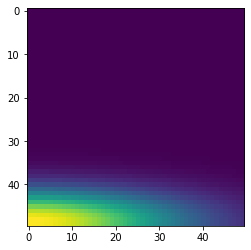

In [3]:
plt.imshow(train_data[10,3])

# Extract descriptors
(this can be done from rdkit or from the descriptor .csv)

In [4]:
df = pd.read_csv("data/Drugbank_some_descriptors.csv")
cntr = 0
for d in df:
    cntr += 1
print(cntr)

126

### Filter descriptors which are unavailable

In [5]:
descriptors = list()

# consider only descriptors which have few missing values and which are floating point
for d in df:
    if df[d].isna().sum() < 800 and df[d].dtype == np.float64:
        descriptors.append(d)

#filter_descriptors = filter(lambda d : "OEselma Descriptors" not in d, descriptors)
#descriptors = list(set(descriptors) - set(filter_descriptors))
num_descriptors = len(descriptors)
print(descriptors)

# select only smiles which have these descriptor values
train_smiles = set(train_molecules)
test_smiles = set(test_molecules)

for i,d in enumerate(descriptors):
    avail_rows = df[np.logical_not(df[d].isna())]
    train_smiles = set(avail_rows["SMILES"]).intersection(train_smiles)
    test_smiles = set(avail_rows["SMILES"]).intersection(test_smiles)

train_idxs = np.asarray(sorted([ train_molecules.index(t) for t in train_smiles ]))
test_idxs = np.asarray(sorted([ test_molecules.index(t) for t in test_smiles ]))

train_molecules = np.asarray(train_molecules)
train_molecules = train_molecules[train_idxs]
train_data = train_data[train_idxs]

test_molecules = np.asarray(test_molecules)
test_molecules = test_molecules[test_idxs]
test_data = test_data[test_idxs]

[
    'ACD Descriptors;logP',
    'ACD logD-logP;logP',
    'MOE Descriptors;h_ema',
    'MOE Descriptors;h_emd',
    'MOE Descriptors;h_emd_c',
    'MOE Descriptors;h_logp',
    'MOE Descriptors;h_logs',
    'MOE Descriptors;h_log_dbo',
    'MOE Descriptors;h_log_pbo',
    'MOE Descriptors;h_mr',
    'OEselma Descriptors;bromine_count',
    'OEselma Descriptors;carbon_count',
    'OEselma Descriptors;clorine_count',
    'OEselma Descriptors;ertl_tpsa',
    'OEselma Descriptors;fluorine_count',
    'OEselma Descriptors;hba',
    'OEselma Descriptors;hba_lipinski',
    'OEselma Descriptors;hbd',
    'OEselma Descriptors;hbd_lipinski',
    'OEselma Descriptors;halogen_count',
    'OEselma Descriptors;iodine_count',
    'OEselma Descriptors;max_flex_chain_1',
    'OEselma Descriptors;max_flex_chain_2',
    'OEselma Descriptors;max_flex_chain_3',
    'OEselma Descriptors;max_rigid_chain',
    'OEselma Descriptors;mol_volume_2d',
    'OEselma Descriptors;mw',
    'OEselma Descriptors;npsa',
    'OEselma Descriptors;neg_ioniz',
    'OEselma Descriptors;nitrogen_count',
    'OEselma Descriptors;nonpolar_count',
    'OEselma Descriptors;nonpolar_count_per_mw',
    'OEselma Descriptors;rigid_frag_count',
    'OEselma Descriptors;aromatic_ring_count',
    'OEselma Descriptors;atom_count',
    'OEselma Descriptors;bond_count',
    'OEselma Descriptors;rigid_bond_count',
    'OEselma Descriptors;ring_count',
    'OEselma Descriptors;rot_bond_count',
    'OEselma Descriptors;oxygen_count',
    'OEselma Descriptors;psa',
    'OEselma Descriptors;phosphorous_count',
    'OEselma Descriptors;polar_count',
    'OEselma Descriptors;polar_count_per_mw',
    'OEselma Descriptors;pos_ioniz',
    'OEselma Descriptors;silicon_count',
    'OEselma Descriptors;sulphur_count',
    'OEselma Descriptors;tsa',
    'Ertl TPSA;Ertl TPSA',
    'Exact Mass;Exact Mass',
    'Heavy Atom Count;Heavy Atom Count',
    'Molecular Volume (2D);Molecular Volume (2D)',
    'Molecular Weight;Molecular Weight',
    'NPSA;NPSA',
    'PSA;PSA',
    'Ring Count;Ring Count',
    'Rotatable Bond Count;Rotatable Bond Count',
    'AZlogD74;prediction',
    'AZlogD74;sd_prediction',
    'ChromlogD;prediction',
    'ChromlogD;sd_prediction',
    'ALogP',
    'Mol Weight',
    'Molar Refractivity',
    'Polarizability',
    'TPSA',
    'Solubility DD Class;confidence',
    'Solubility DD Class;credibility',
    'SCScore;SCScore',
    'AZlogD74 (NN);nearest_neighbours[]- GT similarity',
    'AZlogD74 (NN);nearest_neighbours[]- GT measured',
    'clogP;clogp',
    'clogP;clogp_error',
    'OEselma Descriptors;part_flex_chain'
]

In [6]:
print(train_data.shape, test_data.shape)

(7197, 9, 50, 50)
(1795, 9, 50, 50)

### Build numpy arrays of descriptors

In [7]:
collect()
train_labels = np.empty((train_data.shape[0], num_descriptors))
test_labels = np.empty((test_data.shape[0], num_descriptors))
train_labels[:] = np.nan
test_labels[:] = np.nan

for i,mol in enumerate(tqdm(train_molecules)):
    data_row = df.loc[df['SMILES'] == mol, descriptors ]
    data_vec = [ r.to_list()[-1] for l,r in data_row.items() ]
    train_labels[i,:] = np.asarray(data_vec)

for i,mol in enumerate(tqdm(test_molecules)):
    data_row = df.loc[df['SMILES'] == mol, descriptors ]
    data_vec = [ r.to_list()[-1] for l,r in data_row.items() ]
    test_labels[i,:] = np.asarray(data_vec)

  0%|          | 0/7197 [00:00<?, ?it/s]

  0%|          | 0/1795 [00:00<?, ?it/s]

In [8]:
print(train_labels.shape, test_labels.shape)

(7197, 74)
(1795, 74)

In [9]:
print(not np.isnan(train_labels).any(), not np.isnan(test_labels).any())

True True

In [10]:
with np.printoptions(2, suppress = True):
    print(choice(train_labels))

[  2.07   2.07   4.25   6.91   6.91   7.93   8.72  -4.32   3.05   0.
   0.    18.     0.    39.82   0.     4.     4.     0.     0.     0.
   0.     2.     0.     0.    13.   508.83 293.4  301.22   0.     3.
  17.     0.06   5.     3.    22.    25.    20.     4.     3.     1.
  29.66   0.     1.     0.     0.     0.     0.   331.    39.82 293.15
  22.   508.83 293.4  301.22  29.66   4.     3.     2.07   0.49   1.71
   0.48   1.84 293.36  86.54  34.81  39.82   0.93   0.4    4.21   0.51
   2.54   2.72   0.     2.  ]

# Setup CNN

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Normalization(
        input_shape = train_data.shape[1:],
    ),
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 3, # sliding window
        data_format = "channels_first",
        #input_shape = train_data.shape[1:],
        activation = "relu",
    ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 5,
        activation = "relu"
    ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_descriptors),
])

2022-01-11 18:52:23.653758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 18:52:24.258397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7000 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9, 50, 50)        101       
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 32, 48, 48)        2624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 24, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 20, 32)        38432     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 10, 32)        0         
 2D)                                                             
                                                        

In [13]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = .001),
    loss = "mean_absolute_error",
)

In [14]:
%%time
history = model.fit(
    train_data,
    train_labels,
    verbose = 1,
    epochs = 100,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

2022-01-11 18:52:24.663512: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 518130000 exceeds 10% of free system memory.
2022-01-11 18:52:25.000087: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 518130000 exceeds 10% of free system memory.


Epoch 1/100


2022-01-11 18:52:26.447986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


180/180 [==============================] - ETA: 0s - loss: 22.9602

2022-01-11 18:52:29.288903: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129600000 exceeds 10% of free system memory.
2022-01-11 18:52:29.393406: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129600000 exceeds 10% of free system memory.


180/180 [==============================] - 4s 8ms/step - loss: 22.9602 - val_loss: 18.5249
Epoch 2/100
180/180 [==============================] - 1s 5ms/step - loss: 18.1875 - val_loss: 16.6727
Epoch 3/100
180/180 [==============================] - 1s 5ms/step - loss: 17.5416 - val_loss: 16.5885
Epoch 4/100
180/180 [==============================] - 1s 6ms/step - loss: 16.9988 - val_loss: 16.8551
Epoch 5/100
180/180 [==============================] - 1s 5ms/step - loss: 16.8284 - val_loss: 15.9008
Epoch 6/100
180/180 [==============================] - 1s 6ms/step - loss: 16.6567 - val_loss: 15.4674
Epoch 7/100
180/180 [==============================] - 1s 5ms/step - loss: 16.6025 - val_loss: 15.7255
Epoch 8/100
180/180 [==============================] - 1s 5ms/step - loss: 16.2245 - val_loss: 15.5603
Epoch 9/100
180/180 [==============================] - 1s 6ms/step - loss: 15.9152 - val_loss: 15.5020
Epoch 10/100
180/180 [==============================] - 1s 5ms/step - loss: 16.1988 -

Epoch 80/100
180/180 [==============================] - 1s 5ms/step - loss: 14.4240 - val_loss: 15.2313
Epoch 81/100
180/180 [==============================] - 1s 5ms/step - loss: 14.3265 - val_loss: 14.5063
Epoch 82/100
180/180 [==============================] - 1s 5ms/step - loss: 14.3518 - val_loss: 14.5474
Epoch 83/100
180/180 [==============================] - 1s 5ms/step - loss: 14.3805 - val_loss: 14.7025
Epoch 84/100
180/180 [==============================] - 1s 5ms/step - loss: 14.2388 - val_loss: 14.4054
Epoch 85/100
180/180 [==============================] - 1s 5ms/step - loss: 14.3447 - val_loss: 14.3877
Epoch 86/100
180/180 [==============================] - 1s 5ms/step - loss: 14.2865 - val_loss: 14.6629
Epoch 87/100
180/180 [==============================] - 1s 5ms/step - loss: 14.2067 - val_loss: 14.6375
Epoch 88/100
180/180 [==============================] - 1s 5ms/step - loss: 14.1961 - val_loss: 14.3330
Epoch 89/100
180/180 [==============================] - 1s 5ms/s

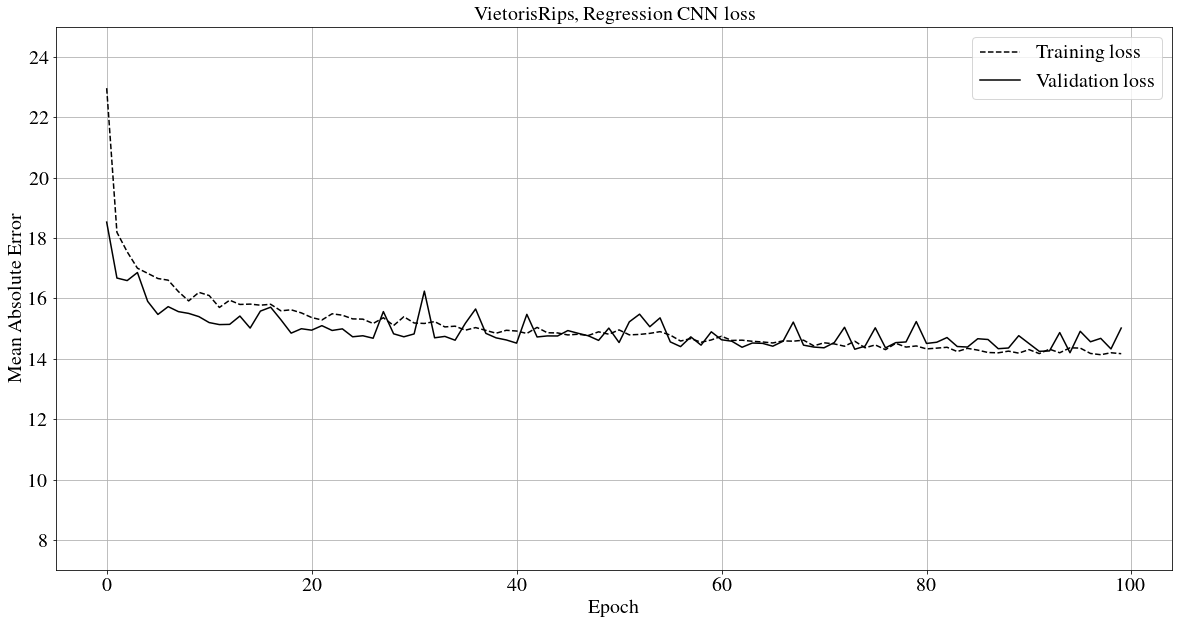

In [20]:
def plot_loss(history):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    p1 = ax.plot(history.history['loss'], "--", color = "black")
    p2 = ax.plot(history.history['val_loss'], color = "black")
    ax.set_ylim([7, 25])
    ax.set_xlabel('Epoch', fontsize = 20)
    ax.set_ylabel('Mean Absolute Error', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(["Training loss", "Validation loss"], fontsize = 20)
    ax.grid(True)
    ax.set_title("VietorisRips, Regression CNN loss", fontsize = 20)
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Times"
})
plot_loss(history)

In [16]:
predicted = model.predict(test_data).reshape((test_data.shape[0],num_descriptors))

2022-01-11 18:54:03.160842: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 161550000 exceeds 10% of free system memory.


In [17]:
out_dict = dict()
out_dict["Descriptor"] = list()
out_dict["_sigma"] = list()
out_dict["Average"] = list()
out_dict["Test Average"] = test_labels.mean(axis = 0)
out_dict["MAE"] = np.abs(test_labels-predicted).mean(axis = 0)
out_dict["Gauss MAE"] = list()

for i,d in enumerate(descriptors):
    out_dict["Descriptor"].append(d)
    out_dict["Average"].append(df[d].mean(skipna = True)) # population mean for this descriptor
    out_dict["_sigma"].append(df[d].std(skipna = True)) # population mean for this descriptor
    out_dict["Gauss MAE"].append(np.abs(
        test_labels[:,i] - np.random.normal(
            loc = df[d].mean(skipna = True),
            scale = df[d].std(skipna = True),
            size = (test_labels.shape[0],1)
        )
    ).mean())
    
out_dict["MAE/sigma"] = out_dict["MAE"]/out_dict["_sigma"]
out_dict["(GMAE*MAE)/sigma"] = out_dict["MAE/sigma"] * out_dict["Gauss MAE"]
    
#out_dict["abs avg diff"] = np.abs(out_dict["Average"] - out_dict["Test Average"])

pd.set_option("display.max_rows", None, "display.max_columns", None)
out_df = pd.DataFrame(data = out_dict)
print(out_dict["MAE"].sum()/len(descriptors)) # THIS IS WHAT tf.keras.losses.MeanAbsoluteError() DOES
out_df = out_df.sort_values("MAE/sigma")
out_df

37.3640626736762

,Descriptor,_sigma,Average,Test Average,MAE,Gauss MAE,MAE/sigma,(GMAE*MAE)/sigma
38,OEselma Descriptors;rot_bond_count,7.213711,6.681677,6.723120,3.301747,7.131755,0.457704,3.264236
65,TPSA,133.333536,107.810334,103.474210,69.642895,119.415706,0.522321,62.373321
3,MOE Descriptors;h_emd,10.821464,12.580101,12.354465,6.251079,10.543166,0.577656,6.090319
64,Polarizability,29.516618,37.783778,37.725149,19.169152,27.955474,0.649436,18.155289
16,OEselma Descriptors;hba_lipinski,5.725688,6.789826,6.627298,3.956887,5.640499,0.691076,3.898014
40,OEselma Descriptors;psa,101.197251,106.494461,101.553941,70.374270,98.265371,0.695417,68.335391
62,Mol Weight,301.265463,374.512520,369.713745,212.699169,276.908437,0.706019,195.502644
13,OEselma Descriptors;ertl_tpsa,94.357347,102.704204,98.604469,68.130070,95.312018,0.722043,68.819384
56,Rotatable Bond Count;Rotatable Bond Count,7.213711,6.681677,6.723120,5.228164,7.182986,0.724754,5.205896
54,PSA;PSA,101.197251,106.494461,101.553941,74.189846,99.829319,0.733121,73.186986


In [18]:
latex_dict = dict()
latex_dict["Descriptors"] = out_dict["Descriptor"]
latex_dict["sigma"]       = out_dict["_sigma"]
latex_dict["Avg"]         = out_dict["Average"]
latex_dict["Test avg"]    = out_dict["Test Average"]
latex_dict["MAE"]         = out_dict["MAE"] 
latex_dict["MAE/sigma"]   = out_dict["MAE/sigma"]
latex_df = pd.DataFrame(data = latex_dict)
latex_df = latex_df.sort_values("MAE/sigma")
latex_df

,Descriptors,sigma,Avg,Test avg,MAE,MAE/sigma
38,OEselma Descriptors;rot_bond_count,7.213711,6.681677,6.723120,3.301747,0.457704
65,TPSA,133.333536,107.810334,103.474210,69.642895,0.522321
3,MOE Descriptors;h_emd,10.821464,12.580101,12.354465,6.251079,0.577656
64,Polarizability,29.516618,37.783778,37.725149,19.169152,0.649436
16,OEselma Descriptors;hba_lipinski,5.725688,6.789826,6.627298,3.956887,0.691076
40,OEselma Descriptors;psa,101.197251,106.494461,101.553941,70.374270,0.695417
62,Mol Weight,301.265463,374.512520,369.713745,212.699169,0.706019
13,OEselma Descriptors;ertl_tpsa,94.357347,102.704204,98.604469,68.130070,0.722043
56,Rotatable Bond Count;Rotatable Bond Count,7.213711,6.681677,6.723120,5.228164,0.724754
54,PSA;PSA,101.197251,106.494461,101.553941,74.189846,0.733121


In [19]:
print(latex_df.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &                                        Descriptors &       sigma &         Avg &    Test
avg &         MAE &   MAE/sigma \\
\midrule
38 &                 OEselma Descriptors;rot\_bond\_count &    7.213711 &    6.681677 &    
6.723120 &    3.301747 &    0.457704 \\
65 &                                               TPSA &  133.333536 &  107.810334 &  
103.474210 &   69.642895 &    0.522321 \\
3  &                              MOE Descriptors;h\_emd &   10.821464 &   12.580101 &   
12.354465 &    6.251079 &    0.577656 \\
64 &                                     Polarizability &   29.516618 &   37.783778 &   
37.725149 &   19.169152 &    0.649436 \\
16 &                   OEselma Descriptors;hba\_lipinski &    5.725688 &    6.789826 &    
6.627298 &    3.956887 &    0.691076 \\
40 &                            OEselma Descriptors;psa &  101.197251 &  106.494461 &  
101.553941 &   70.374270 &    0.695417 \\
62 &                                         Mol Weight &  301.265463 &  374.512520 &  
369.713745 &  212.699169 &    0.706019 \\
13 &                      OEselma Descriptors;ertl\_tpsa &   94.357347 &  102.704204 &   
98.604469 &   68.130070 &    0.722043 \\
56 &          Rotatable Bond Count;Rotatable Bond Count &    7.213711 &    6.681677 &    
6.723120 &    5.228164 &    0.724754 \\
54 &                                            PSA;PSA &  101.197251 &  106.494461 &  
101.553941 &   74.189846 &    0.733121 \\
4  &                            MOE Descriptors;h\_emd\_c &    5.020204 &    6.492526 &    
6.589198 &    3.688812 &    0.734793 \\
48 &                                Ertl TPSA;Ertl TPSA &   94.357347 &  102.704204 &   
98.604469 &   69.392941 &    0.735427 \\
63 &                                 Molar Refractivity &   74.060489 &   95.559089 &   
95.617436 &   54.507271 &    0.735983 \\
50 &                  Heavy Atom Count;Heavy Atom Count &   15.757548 &   25.426522 &   
25.469638 &   11.702000 &    0.742628 \\
51 &        Molecular Volume (2D);Molecular Volume (2D) &  371.986946 &  592.330629 &  
585.774184 &  286.656463 &    0.770609 \\
6  &                             MOE Descriptors;h\_logs &    5.975325 &    9.838051 &    
9.721990 &    4.657743 &    0.779496 \\
8  &                          MOE Descriptors;h\_log\_pbo &    3.788166 &    1.932621 &    
2.229802 &    2.981169 &    0.786969 \\
53 &                                          NPSA;NPSA &  200.207940 &  307.642466 &  
311.788064 &  159.869191 &    0.798516 \\
27 &                           OEselma Descriptors;npsa &  200.207940 &  307.642466 &  
311.788064 &  160.491176 &    0.801622 \\
25 &                  OEselma Descriptors;mol\_volume\_2d &  371.986946 &  592.330629 &  
585.774184 &  298.307208 &    0.801929 \\
30 &                 OEselma Descriptors;nonpolar\_count &    9.445993 &   12.086764 &   
12.591086 &    7.891114 &    0.835393 \\
47 &                            OEselma Descriptors;tsa &  261.688962 &  414.138860 &  
413.351532 &  222.508635 &    0.850279 \\
11 &                   OEselma Descriptors;carbon\_count &   11.377305 &   17.636929 &   
17.909192 &    9.835752 &    0.864506 \\
72 &                                  clogP;clogp\_error &   24.318937 &   20.365517 &   
18.168802 &   21.906351 &    0.900794 \\
42 &                    OEselma Descriptors;polar\_count &    5.731492 &    6.059067 &    
5.859610 &    5.205672 &    0.908258 \\
49 &                              Exact Mass;Exact Mass &  227.548842 &  372.828687 &  
369.350378 &  208.011052 &    0.914138 \\
29 &                 OEselma Descriptors;nitrogen\_count &    2.861234 &    2.583797 &    
2.578830 &    2.641041 &    0.923042 \\
26 &                             OEselma Descriptors;mw &  227.821937 &  373.328639 &  
369.712925 &  218.367377 &    0.958500 \\
52 &                  Molecular Weight;Molecular Weight &  227.821937 &  373.328639 &  
369.712925 &  220.848590 &    0.969391 \\
24 &                OEselma Descriptors;m